본 코드는 colab에서 구동 확인 함
- 로컬에서 안 되는 예제

In [ ]:
# 환경 설정
!pip install git+https://github.com/autodistill/autodistill-grounded-sam-2 rf_groundingdino -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 45.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 39.1 MB/s eta 0:00:00


In [ ]:
# # 테스트 데이터 수집
# !wget https://media.roboflow.com/containers.zip
# !unzip containers.zip

--2024-11-21 09:58:08--  https://media.roboflow.com/containers.zip
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12356763 (12M) [application/zip]
Saving to: ‘containers.zip’

containers.zip      100%[===================>]  11.78M  7.34MB/s    in 1.6s    

2024-11-21 09:58:10 (7.34 MB/s) - ‘containers.zip’ saved [12356763/12356763]

Archive:  containers.zip
   creating: containers/
  inflating: containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-75_jpg.rf.ffbb8716eb886f91e3a561e2ba4be074.jpg  
  inflating: __MACOSX/containers/._Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-75_jpg.rf.ffbb8716eb886f91e3a561e2ba4be074.jpg  
  inflating: containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-169_jpg.rf.c0bf90f4b4bf5450508f6ccd5fd85e79.jpg  
  inflating: __MACOSX/containers/._Tips-and-tricks-on-how-to-park-a-ya

In [ ]:
# SAM2 load
from autodistill_grounded_sam_2 import GroundedSAM2

Importing from timm.models.layers is deprecated, please import via timm.layers


In [ ]:
# 압축된 라벨링 이미지 unzip
  # unzip /content/04011007.zip

import zipfile
import os

def unzip(zip_filepath, extract_dir=None):
  """
  unzip
  extract_dir: 기본값 None == zip파일과 같은 디렉토리에 해제
  """
  try:
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            if extract_dir is None:
                extract_dir = os.path.dirname(zip_filepath) # zip 파일과 같은 디렉토리

            zip_ref.extractall(extract_dir)
            print(f"{zip_filepath} 파일 압축 해제 완료. {extract_dir}에 저장되었습니다.")

  except FileNotFoundError: # 파일이 없는 경우 예외처리
        print(f"오류: {zip_filepath} 파일을 찾을 수 없습니다.")
  except zipfile.BadZipFile: # 잘못된 zip 파일인 경우 예외처리
        print(f"오류: {zip_filepath} 파일이 손상되었거나 잘못된 zip 파일입니다.")
  except Exception as e: # 기타 예외 처리
        print(f"오류: 압축 해제 중 오류가 발생했습니다: {e}")

# 사용 예시:
zip_file = "/content/04011007.zip"  # 압축 해제할 zip 파일 경로
extract_location = "/content/" # 압축 해제할 디렉토리 (선택)

# unzip(zip_file)  # zip 파일과 같은 디렉토리에 압축 해제
unzip(zip_file, extract_location)  # 지정된 디렉토리에 압축 해제

/content/04011007.zip 파일 압축 해제 완료. /content/에 저장되었습니다.


In [ ]:
# 모델 불러오기/캡션

from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import numpy as np
import cv2
import os
import random
import supervision as sv

# define an ontology to map class names to our Grounded SAM 2 prompt
# the ontology dictionary has the format {caption: class}
# where caption is the prompt sent to the base model, and class is the label that will
# be saved for that caption in the generated annotations
# then, load the model
base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "A traditional Korean soup made with beef, radish, kelp, green onions, soy sauce, salt, and other ingredients. It features a clear broth with beef and radish. Only the food in the bowl or pots": "Beef and radish soup"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.33
)


trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


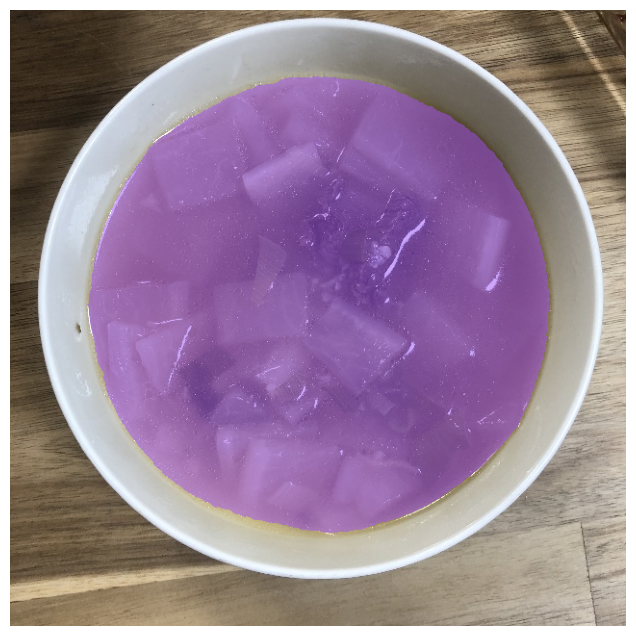

In [ ]:
# 이미지 경로 설정/라벨링 미리보기

IMAGE_DIR = "/content/src"
IMAGE_PATH = os.path.join(IMAGE_DIR, random.choice(os.listdir(IMAGE_DIR)))

results = base_model.predict(IMAGE_PATH).with_nms()
results = results[results.confidence > 0.1]

image = cv2.imread(IMAGE_PATH)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
# 모델에 넣기

try:
    base_model.label(IMAGE_DIR, extension="jpg")
except Exception as e:
    print(f"라벨 생성 중 오류 발생: {e}")

Labeling /content/src/04_041_04011007_160739939769205_1.jpg: 100%|██████████| 916/916 [04:24<00:00,  3.46it/s]


Labeled dataset created - ready for distillation.


In [ ]:
# 결과 파일 > 압축 > PC로 다운로드(다운로드 폴더)

import os
import shutil
from google.colab import files

def download_folder_as_zip(folder_path):
    """
    Colab에서 폴더를 zip 파일로 압축하고 다운로드합니다.

    Args:
        folder_path (str): 다운로드할 폴더 경로
    """
    # 1. 압축 파일 이름 설정
    zip_filename = os.path.basename(folder_path) + ".zip" # 폴더명.zip


    # 2. 폴더 압축
    try:
        shutil.make_archive(zip_filename[:-4], 'zip', folder_path)  # 폴더 압축, 확장자 제외한 파일명 사용
        print(f"{folder_path} 폴더를 {zip_filename} 파일로 압축했습니다.")

    except Exception as e:
        print(f"압축 중 오류 발생: {e}")
        return


    # 3. 압축 파일 다운로드
    try:
        files.download(zip_filename) # 압축 파일 다운로드
        print(f"{zip_filename} 파일 다운로드 완료.")


    except Exception as e:
        print(f"다운로드 중 오류 발생: {e}")

    # 4. 압축 파일 삭제 (선택 사항)
    # os.remove(zip_filename) # 다운로드 후 압축 파일 삭제


# 사용 예시:
folder_path = "/content/drive/MyDrive/Colab Notebooks/4_labeled" # 다운로드할 폴더 경로
download_folder_as_zip(folder_path) # 함수 호출

/content/drive/MyDrive/Colab Notebooks/4_labeled 폴더를 4_labeled.zip 파일로 압축했습니다.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4_labeled.zip 파일 다운로드 완료.
